## Sentiment Analysis: Toxicity Classification Model
@ Victor Saidi Phiri

## Data Discription

The perpose of this lab is to create a model that will be able to classify tweets as toxic or non toxic. The model will be trained on the a manually coded code book  with poplar tweets that have been classified as toxic and non toxic.

This task uses the Social Media Toxicity Dataset obtained from Surge. The data contains 500 toxic comments and 500 non toxic comments from popular tweets. I will use machine learning to select a model that can best classify the tweets as toxic and non toxic. To this end, both SVM and Naive Bayes will computed and the findings will be compared to the performance of the pretrained model. In addtion, the results will be compared to the study by (Sidorov etal., n), who investigated Machining learning approach for opinion mining on tweets. 

### Definition of terms

**Toxic comment**: "violence against or directly attack[ing] or threaten[ing] other people on the basis of race, ethnicity, national origin, sexual orientation, gender, gender identity, religious affiliation, age, disability or disease"-(Persily and Tucker, 2020, p. 61)

**Non toxic comment**: Civil comments that do not fall into the cagorization of toxicity


In [1]:
# Packages  
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

# Data Exploration  
In this section I will explore the data to understand the structure and the contents

In [2]:
# load datasets 
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv("https://raw.githubusercontent.com/Visap1/MyFirstRepo/main/Social%20Media%20Toxicity%20Dataset.csv")
len(df)# check number of roles 

df.head()


,worker_id,task_id,task_response_id,is_reviewed,review_score,text,Is this text toxic?
0,ZVDKTXAXYHRV,d309deac-784d-4d7b-8fff-01f4a258fc48,002fe204-d495-4eca-abac-af0129dd11c3,False,NaN,when my cat calls it a night and curls up next...,Not Toxic
1,XJKGQQWFXKTX,3132ddc4-b762-4757-b731-477073bb38ab,0052e1ce-a7d4-4902-a8a3-ae9177bbd139,False,NaN,Bjergsen moving to C9 Academy for sure. Darsha...,Not Toxic
2,DKJR6EW9AWVD,1bec4e23-7db5-4a5f-acac-08526c29bf20,0136f9eb-d957-4e46-b43b-03c24cfb54bf,False,NaN,Waiting for Hadestown announcements....,Not Toxic
3,PJGJWJY2PNKC,21217e8b-df0e-4f86-8c19-cd3459fa1b23,014e7335-1665-46ee-b795-2d697ed7a2e9,False,NaN,How about you fk off with your stupid spider. ...,Toxic
4,4KDNMYPMNZXC,0c0792c9-3852-491a-8a25-818af2bd7705,015a8fb2-873e-45ab-bfb6-cf258c017f84,False,NaN,""" Amazing Humans""????Not in my book( Pun inten...",Toxic


### Select and Remane Columns 

I selected the relevant columns with text and sentiments for my analysis. Further, I renamed the Is this text column into sentiment.  In addition, the graphs show that the data has 50%(500) of the comments were toxic, and 50%(500) were nontoxic. It is important to also note that the sentiments are not arrange in a specific order. 

In [3]:
sub_df= df[['text','Is this text toxic?']]# we selected text and coding 
sub_df.rename(columns = {'Is this text toxic?':'sentiment'}, inplace = True)
sub_df


,text,sentiment
0,when my cat calls it a night and curls up next...,Not Toxic
1,Bjergsen moving to C9 Academy for sure. Darsha...,Not Toxic
2,Waiting for Hadestown announcements....,Not Toxic
3,How about you fk off with your stupid spider. ...,Toxic
4,""" Amazing Humans""????Not in my book( Pun inten...",Toxic
...,...,...
995,"I did not only post it on reddit, altough I'm ...",Not Toxic
996,"Seriously, why is she still in office! I bet s...",Toxic
997,Barely 72 hours after C9 gets spanked and they...,Not Toxic
998,Build a new Mayflower that can be used to send...,Toxic


<AxesSubplot:ylabel='sentiment'>

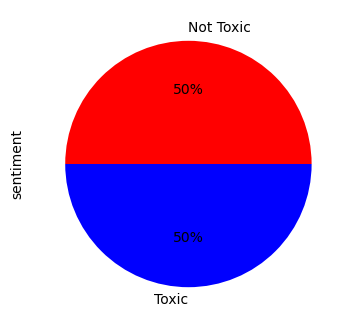

In [4]:
sub_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%',
                                   figsize=(4,4),colors=["red", "blue"])

In [5]:
# check the counts of toxic comments 
import numpy as pd 
sub_df['sentiment'].value_counts()
#sub_df.isnull().any() #no missing values 

Not Toxic    500
Toxic        500
Name: sentiment, dtype: int64

##  Pre-processing

This phase focuses on preparing data for machine learning. This involves dealing with url, stopwords, 'stemming,’ and 'lemmatize' the tweets. The sentences will also be set to lowercase. Kedia and Rasu(2020, p. 149) argue that “poorly processed data  are guaranteed to train models with low accuracy.” To avaoid this pitfall, I cleaned the data and created a new column called clean text with processed information. 

In [6]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


sub_df['cleanText']=sub_df['text'].map(lambda s:preprocess(s)) 

### LabelEncoder (*Transform Categorical variables*) 

The sentiment column will be transformed using the *labelEncorder* from sklearn. This will help in preparing data for the ML model. ML does not work with categorical data but numeric variables (Kedia and Rasu, 2020, p. 151). Hence the column will be transformed to have 0(Nontoxic) and 1(Toxic) comments. 

In [7]:
le=LabelEncoder()
label = le.fit_transform(sub_df['sentiment'])
# drop the category column
sub_df.drop("sentiment", axis=1, inplace=True)
# add the transformed labels to the dataframe 
sub_df["sentiment"] = label
sub_df.head()

,text,cleanText,sentiment
0,when my cat calls it a night and curls up next...,cat calls night curls next bed literally feel ...,0
1,Bjergsen moving to C9 Academy for sure. Darsha...,bjergsen moving academy sure darshan enticing ...,0
2,Waiting for Hadestown announcements....,waiting hadestown announcements,0
3,How about you fk off with your stupid spider. ...,stupid spider btw live never follow shit,1
4,""" Amazing Humans""????Not in my book( Pun inten...",amazing humans book pun intended terrible conf...,1


## Count vectorizer, TFID Transformer
I will use the Count vectoriser from sklearn to convert our list into a matrix. Further I use TFID to vectorise the text and  extracting feactures. Further, I will use the clained text column(cleanText) in the dataset. 


In [8]:
X = sub_df.iloc[:,1] # extract column with text(tweets)

y = sub_df.iloc[:,- 1] # extract column with category(toxic or not toxic)

# Count Vectorizer 

vectorizer= CountVectorizer(stop_words='english')
X_vec=vectorizer.fit_transform(X)
X_vec= X_vec.todense() #convert sparse matrix into dense matrix
#len(X_vec)

# The Tfidtransformer 

tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_vec)
X_tfidf = X_tfidf.todense()

X_tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Model 1: Naive Bayes Algorithm
I split the data into two, in which (750)75% will be in the training dataset while (250)25% will be used for the testing dataset. I will then use the Multinomial Naive Bayes class from sklearn and fit the training data on the model. This implies that the NB classifier has learned the data and can classify the text as either toxic or not toxic. Further, the predicted probabilities of the model will be stored ion y_pred. This processes is guided by (Kedia and Rasu 2020, p. 161). 

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Create Training and Testing dataset 
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, 
                                                   test_size = 0.25, random_state = 0)
#Create a Beyes Model
clf = MultinomialNB() 
clf.fit(X_train, y_train)
# predict sentiments on the test X dataset 
y_pred = clf.predict(X_test)

### Performance of the Model

The confusion matrix will be used to assess the performance of the model. The matrix "calculates the number of correct predictions broken down for each classification" . I will show the percentage per classification and actual counts.  The code for visualizing the matrix was obtained from the following source:
https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/ 


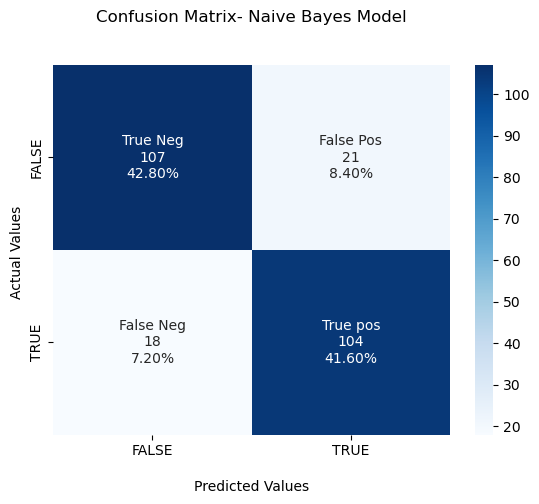

In [10]:
from sklearn.metrics import confusion_matrix,accuracy_score 
import numpy as np
import seaborn as sns 
cf_matrix=confusion_matrix(y_test,y_pred)

group_names = ['True Neg','False Pos','False Neg','True pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix- Naive Bayes Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

##  labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['FALSE','TRUE'])
ax.yaxis.set_ticklabels(['FALSE','TRUE'])

## Display the visualization of the Confusion Matrix.
plt.show()
 
#confusion_matrix(y_test, y_pred)

The confusion Matrix above shows that the model predicted a score of 125 values as 0(not toxic), of which 107(42.8%) were correctly predicted while 18(7.20%) were incorrectly predicted. Further, 125 were predicted as toxic with a score of 1, out of which 104(41.80) were correctly predicted while 21(8.40%) were incorrectly predicted. The overall performance of the model was 84%. Additionally, precession at predicting nontoxic and toxic comments was 86% and 83% respectively. Below is the classification report.

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
#accuracy_score(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       128
           1       0.83      0.85      0.84       122

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250



## Model 2 :SVC Algorithm 

In [12]:
from sklearn.svm import SVC 
classifier = SVC(kernel='linear') 
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)

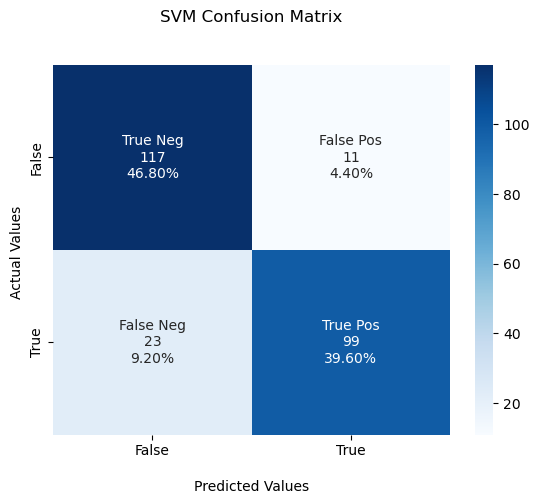

In [13]:
from sklearn.metrics import confusion_matrix 

CF_matrix=confusion_matrix(y_test, Y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                CF_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     CF_matrix.flatten()/np.sum(CF_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(CF_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('SVM Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
#confusion_matrix(y_test,Y_pred)

In [14]:
accuracy_score(y_test,Y_pred)
print(classification_report(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       128
           1       0.90      0.81      0.85       122

    accuracy                           0.86       250
   macro avg       0.87      0.86      0.86       250
weighted avg       0.87      0.86      0.86       250



The confusion Matrix above shows that the model predicted a score of 140 values as 0(not toxic), of which 117 were correctly predicted while 23(9.20%) were incorrectly predicted. Further, 110 were predicted as toxic with a score of 1, out of which 99(39.60%) were correctly predicted while 11(4.40%) were incorrectly predicted. The overall performance of the model was 86%. Additionally, precession at predicting nontoxic and toxic comments was 84% and 90% respectively. Below is classification report of the model. 


### Discussion 
 
We can see from the results that SVM model performed better at classifying toxic comments. In addition, the model had a higher precision score of 86%, which is better than 84% of the NB model. This proves the results obtained by (Sidorov etal., n) they found that the SVM model had 86% precision while NB model had 78%. The study recommended a sample of 3000 tweets and the use of n-gram, using two polarity classes (positive and negative). They argue that if these are in place, the SVM model will record 85% precision. However, I found 86% precision with a sample of 1000 tweets. Another study by (Vikashi and Suyash, 2016, p. 1626) also established that SMV with linear SVC Improves classification effectiveness. The study found a good precision score of 93%. However, I acknowledge in this study that it would have been better to compare the performance of the models with the pre-trained models available on Hugging face(e.g transformer). The researcher tried to install the models but was unsuccessful with the installation due to technical issues with the computer. 

### Uses of the model 

The models are useful in social sciences, especially in regulating hate speech on social media. However, there is a need to expand the model's vocabulary to capture information that is not in English. 


In [ ]:
#
vad_pred=new_df1.iloc[:,-1]
Actual=new_df1.iloc[:,1]

#confusion_matrix(Actual,vad_pred)
from wordcloud import WordCloud, STOPWORDS



In [ ]:
from nltk.stem import WordNetLemmatizer
lemmer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import TweetTokenizer

sub_df.head() 

In [ ]:
def wordcloud_plot(category, name) : 
    plt.figure(figsize=(20,15))
    wc = WordCloud(background_color="black", max_words=500, min_font_size=6 
                 , stopwords=stopwords, max_font_size= 60)
    wc.generate(" ".join(category))
    plt.title("Twitter Wordlcloud " + name +  " Comments", fontsize=30)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Set1' , random_state=21), alpha=0.98)
    plt.axis('off')
    plt.savefig(name+'_wc.png')
    return(True)

wordcloud_plot(toxic,'Toxic')

### References 

Bail, C., 2021. Breaking the social media prism: how to make our platforms less polarizing. Princeton University Press, Princeton.\\

Journal, I., n.d. SENTIMENT ANALYSIS OF TWITTER DATA.\\

Persily, N., Tucker, J.A. (Eds.), 2020. Social Media and Democracy: The State of the Field, Prospects for Reform, SSRC Anxieties of Democracy. Cambridge University Press, Cambridge. https://doi.org/10.1017/9781108890960\\

Grigori sidorove, Sabino Miranda Francisco Vivero(n): Empirical study of machine learning based approach\\


https://www.kaggle.com/code/binodsharma1/twitter-sentiment-analysis\\

https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

## Apendix 

In [18]:
 
toxic1=sub_df[sub_df.sentiment==1]['text'].values
import numpy as np
import pandas as pd

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])
    
toxic_df = pd.DataFrame(toxic1,columns=['text'])
toxic_df1=toxic_df.iloc[:,0]

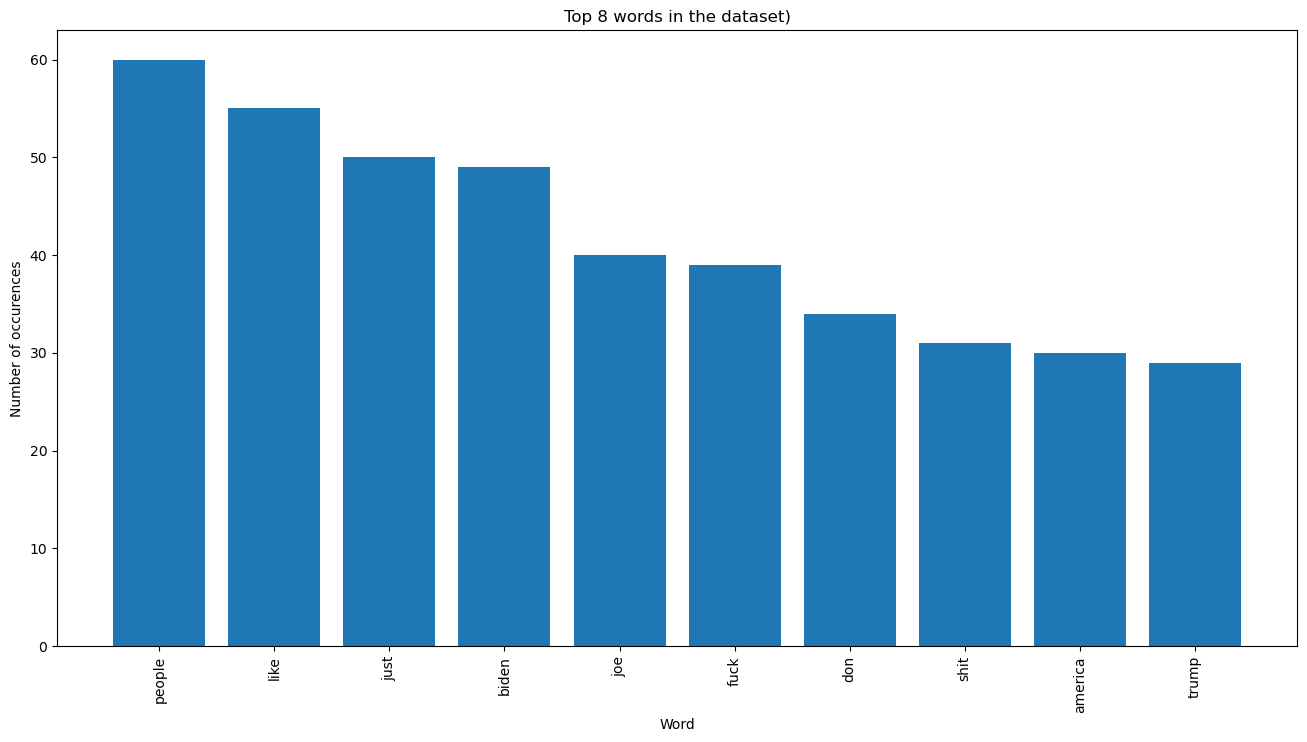

In [20]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=toxic_df1)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 8 words in the dataset)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()